In [119]:
from __future__ import print_function, division
import numpy as np
import functools
import matplotlib.pyplot as plt
import time
import xgboost as xgb

In [120]:
matrix_size = (10000, 1000)
## Helper functions
def extract_line_data(l):
    us = l.index('_')
    row = int(l[1:us])-1
    com = l.index(',')
    col = int(l[us+2:com])-1
    val = float(l[com+1:l.index('\n')])
    return (row, col, val)
    
def read_data(file_name):
    print("Reading file %s" % file_name)
    Atr = np.zeros(matrix_size, dtype=float)
    
    with open(file_name, 'r') as fh:
        data = fh.readlines()
    
    for i, l in enumerate(data[1:]):
        row, col, val = extract_line_data(l)
        Atr[row, col] = val

    return Atr

def write_predict(pfunc, M, fn):
    with open(fn, 'w') as fh:
        fh.write("Id,Prediction\n")
        for x in range(M.shape[0]):
            for y in range(M.shape[1]):
                if M[x, y] == True:
                    fh.write("r%d_c%d,%f\n" % (x+1, y+1, pfunc(x, y)))

In [144]:
do_predictions = False

In [122]:
# Read true training labels
train_labels = read_data("data_train.csv")
test_labels = read_data("sampleSubmission.csv")

Reading file data_train.csv
Reading file sampleSubmission.csv


In [132]:
# Split validation and training
train_indices = np.array(np.where(train_labels != 0)).T
if do_predictions:
    valid_size = 0
else:
    valid_size = train_indices.shape[0]//4

valid_indices_tmp = np.random.choice(range(train_indices.shape[0]), 
                                     size=(valid_size, ), 
                                     replace=False)
valid_indices = train_indices[valid_indices_tmp,:]
train_indices = np.delete(train_indices, valid_indices_tmp, axis=0)

In [133]:
## Read data into xgboost matrices
load_from_disk = False
predictor_files = [
  "./saved_data/final_submissions/autoenc_ax0_test.csv",    "./saved_data/final_submissions/autoenc_ax0_train.csv",
  "./saved_data/final_submissions/autoenc_ax1_test.csv",    "./saved_data/final_submissions/autoenc_ax1_train.csv", 
  "./saved_data/final_submissions/neighbourhood_test.csv",  "./saved_data/final_submissions/neighbourhood_train.csv",
  "./saved_data/final_submissions/SGD++_test.csv",          "./saved_data/final_submissions/SGD++_train.csv",
  "./saved_data/final_submissions/integrated_test.csv",     "./saved_data/final_submissions/integrated_train.csv",
  "./saved_data/final_submissions/simple_test.csv",         "./saved_data/final_submissions/simple_train.csv"            
]
#predictor_files = [
# "./saved_data/final_submissions/submit_xgboost.csv_Integrated_test.csv",    "./saved_data/final_submissions/submit_xgboost.csv_Integrated_train.csv",
# "./saved_data/final_submissions/submit_xgboost.csv_SGD++_test.csv",         "./saved_data/final_submissions/submit_xgboost.csv_SGD++_train.csv",
# "./saved_data/final_submissions/submit_xgboost.csv_Neighbourhood_test.csv", "./saved_data/final_submissions/submit_xgboost.csv_Neighbourhood_train.csv",
# "./saved_data/final_submissions/submit_xgboost.csv_simple_test.csv",        "./saved_data/final_submissions/submit_xgboost.csv_simple_train.csv"]
# Read feature vectors from disk
train_stack = []
test_stack = []
valid_stack = []
#valid_labels = 
for pf in predictor_files:
    data = read_data(pf)
    if "train" in pf:
        flat_tr_data = data[tuple([train_indices[:,0], train_indices[:,1]])]
        train_stack.append(flat_tr_data)
        flat_vl_data = data[tuple([valid_indices[:,0], valid_indices[:,1]])]
        valid_stack.append(flat_vl_data)
    elif "test" in pf:
        flat_data = data[np.where(test_labels != 0)]
        test_stack.append(flat_data)
    else:
        print("Unknown file: %s" % pf)



Reading file ./saved_data/final_submissions/autoenc_ax0_test.csv
Reading file ./saved_data/final_submissions/autoenc_ax0_train.csv
Reading file ./saved_data/final_submissions/autoenc_ax1_test.csv
Reading file ./saved_data/final_submissions/autoenc_ax1_train.csv
Reading file ./saved_data/final_submissions/neighbourhood_test.csv
Reading file ./saved_data/final_submissions/neighbourhood_train.csv
Reading file ./saved_data/final_submissions/SGD++_test.csv
Reading file ./saved_data/final_submissions/SGD++_train.csv
Reading file ./saved_data/final_submissions/integrated_test.csv
Reading file ./saved_data/final_submissions/integrated_train.csv
Reading file ./saved_data/final_submissions/simple_test.csv
Reading file ./saved_data/final_submissions/simple_train.csv


In [134]:
x_train = np.vstack(train_stack).T
print(x_train.shape)
y_train = train_labels[tuple([train_indices[:,0], train_indices[:,1]])]
print(y_train.shape)

if do_predictions:
    x_test = np.vstack(test_stack).T
    print(x_test.shape)
    y_test = None
else:
    x_test = np.vstack(valid_stack).T
    print(x_test.shape)
    y_test = train_labels[tuple([valid_indices[:,0], valid_indices[:,1]])]
    print(y_test.shape)


(1176952, 6)
(1176952,)
(1176952, 6)


In [135]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_test, label=y_test)

In [142]:
d_train = xgb.DMatrix("saved_data/train.buffer")
d_valid = xgb.DMatrix("saved_data/valid.buffer")

In [153]:
print(d_train.get_label().shape)
print(d_valid.get_label().shape)

(1176952,)
(235194,)


In [154]:
## XGBoost run
params = {}
params['objective'] = "reg:linear"
#params['base_score'] = np.mean(y_train)
params['eval_metric'] = "rmse"
params['seed'] = 12391
params['eta'] = 0.1
params['max_depth'] = 2
params['min_child_weight'] = 1
params['alpha'] = 100
params['lambda'] = 100
params['subsample'] = 0.5
num_round = 100
early_stop = 20

watchlist = [(d_train, 'train')]
#if not do_predictions:
#    watchlist.append((d_valid, 'valid'))
# Perform training.
bst = xgb.train(params, d_train, num_round, watchlist, early_stopping_rounds=early_stop, verbose_eval=10)

#if not do_predictions:
#    cvresult = xgb.cv(params, d_train, num_boost_round=num_round, nfold=5,
#            metrics='rmse', early_stopping_rounds=early_stop, verbose_eval=10)


[0]	train-rmse:3.21021
Will train until train-rmse hasn't improved in 20 rounds.
[10]	train-rmse:1.38995


KeyboardInterrupt: 

In [155]:
xgb.cv(params, d_train, num_boost_round=num_round, nfold=5,
            metrics='rmse', early_stopping_rounds=early_stop, verbose_eval=10)

[0]	train-rmse:3.21031+0.000199725	test-rmse:3.21031+0.00133591
[10]	train-rmse:1.38993+0.000128936	test-rmse:1.38997+0.00117125
[20]	train-rmse:0.922725+0.000240366	test-rmse:0.922861+0.000818345
[30]	train-rmse:0.8331+0.000207216	test-rmse:0.833281+0.000854566


KeyboardInterrupt: 

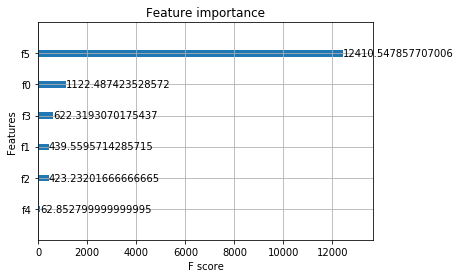

In [137]:
# TODO: find a way to get the names of the features!
xgb.plot_importance(bst, importance_type="gain")#, max_num_features=None)
plt.show()

In [138]:
# Make predictions
ypred = bst.predict(d_valid)
submit_file = "./saved_data/submit_xgboost.csv"
print("Writing results to %s" % submit_file)
with open(submit_file, 'w') as fh:
    fh.write("Id,Prediction\n")
    indices = np.where(test_labels != 0)
    for index in range(len(indices[0])):
        u = indices[0][index]
        i = indices[1][index]
        fh.write("r%d_c%d,%f\n" % (u+1, i+1, ypred[index]))

Writing results to ./saved_data/submit_xgboost.csv
